## 测量因子

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import single

from Utility.factorFactory import FactorFactory
from Utility.Util import evaluate_time_series_ic
import matplotlib.pyplot as plt

/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### （1）预处理数据：

In [2]:
df = pd.read_csv ('df_minute.csv')
df.shape

(1920, 16)

In [3]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'dollar_volume',
       'vwap', 'tick_count', 'trade_size_mean', 'trade_size_std',
       'zero_return_count', 'price_direction_ratio', 'large_trade_count',
       'large_trade_ratio', 'large_trade_volume_ratio'],
      dtype='object')

In [4]:
finfact = FactorFactory (df, forward_period=5, window=100, scaler='minmax', top_k=1000)

In [5]:
finfact.generate_factors (mode='thread', n_job=4, bounded_only=True)
df_featured = finfact.df_features
df_featured.shape

🔄 cross_op (thread): 100%|██████████| 22050/22050 [00:00<00:00, 732648.38it/s]


(1703, 1001)

### （3）评测因子：

In [6]:
finfact.get_summary ()

,spearman_ic,pearson_ir,pca_coeff,spearman_ic_norm,pearson_ir_norm,pca_coeff_norm,combined_score
rsi_14_price_direction_ratio_minus_rsi_14_close,0.0648,1.3913,0.0106,0.8089,1.0000,0.8975,2.7064
rsi_14_price_direction_ratio_minus_rsi_10_close,0.0629,1.2646,0.0112,0.8000,0.9545,0.9451,2.6996
rsi_10_price_direction_ratio_minus_rsi_10_close,0.0641,1.2593,0.0110,0.8056,0.9526,0.9319,2.6901
rsi_10_price_direction_ratio_minus_rsi_14_close,0.0663,1.3767,0.0104,0.8160,0.9948,0.8765,2.6872
bb_pband_20_1.5_price_direction_ratio_minus_rsi_14_close,0.0590,1.3721,0.0107,0.7811,0.9931,0.9043,2.6785
...,...,...,...,...,...,...,...
rsi_14_trade_size_mean_minus_rsi_14_vwap,0.0427,0.8573,0.0092,0.7035,0.8081,0.7784,2.2900
rsi_6_trade_size_std_minus_rsi_6_close,0.0502,0.9769,0.0083,0.7393,0.8511,0.6986,2.2890
rsi_10_trade_size_mean_minus_rsi_6_close,0.0411,0.8469,0.0093,0.6961,0.8044,0.7883,2.2888
rsi_6_large_trade_count_minus_rsi_10_vwap,0.0496,0.8197,0.0089,0.7365,0.7946,0.7549,2.2860


In [7]:
cur_features = finfact.next(steps=5, k=10, mode='thread', n_job=6, bounded_only=True)

🔄 next steps: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


In [8]:
df_features = finfact.df_features
df_features.columns.tolist()

['timestamp',
 'rsi_14_price_direction_ratio_minus_rsi_14_close_minus_bb_pband_20_2.0_low_minus_bb_pband_20_1.5_low_mul_rsi_10_large_trade_ratio_minus_rsi_14_high_mul_rsi_10_large_trade_ratio_minus_rsi_14_high_minus_cos_rsi_14_price_direction_ratio_minus_rsi_14_close_mul_sin_rsi_6_large_trade_volume_ratio_minus_rsi_6_vwap_minus_bb_pband_20_2.0_sin_rsi_10_large_trade_ratio_minus_rsi_14_high_minus_bb_pband_20_2.0_cos_rsi_6_tick_count_minus_rsi_10_close_minus_sin_cos_rsi_10_large_trade_ratio_minus_rsi_14_high_mul_rsi_14_price_direction_ratio_minus_rsi_14_close_minus_bb_pband_20_2.0_low_minus_bb_pband_20_1.5_low',
 'rsi_14_price_direction_ratio_minus_rsi_14_close_minus_bb_pband_20_2.0_low_minus_bb_pband_20_1.5_low_mul_rsi_10_large_trade_ratio_minus_rsi_14_high_mul_rsi_10_large_trade_ratio_minus_rsi_14_high_minus_cos_rsi_14_price_direction_ratio_minus_rsi_14_close_mul_sin_rsi_6_large_trade_volume_ratio_minus_rsi_6_vwap_minus_bb_pband_20_2.0_sin_rsi_10_large_trade_ratio_minus_rsi_14_high_min

🔄 窗口展平: 100%|██████████| 1353/1353 [00:00<00:00, 13698.77it/s]
/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
🔄 并行降维: 100%|██████████| 6/6 [00:50<00:00,  8.40s/it]


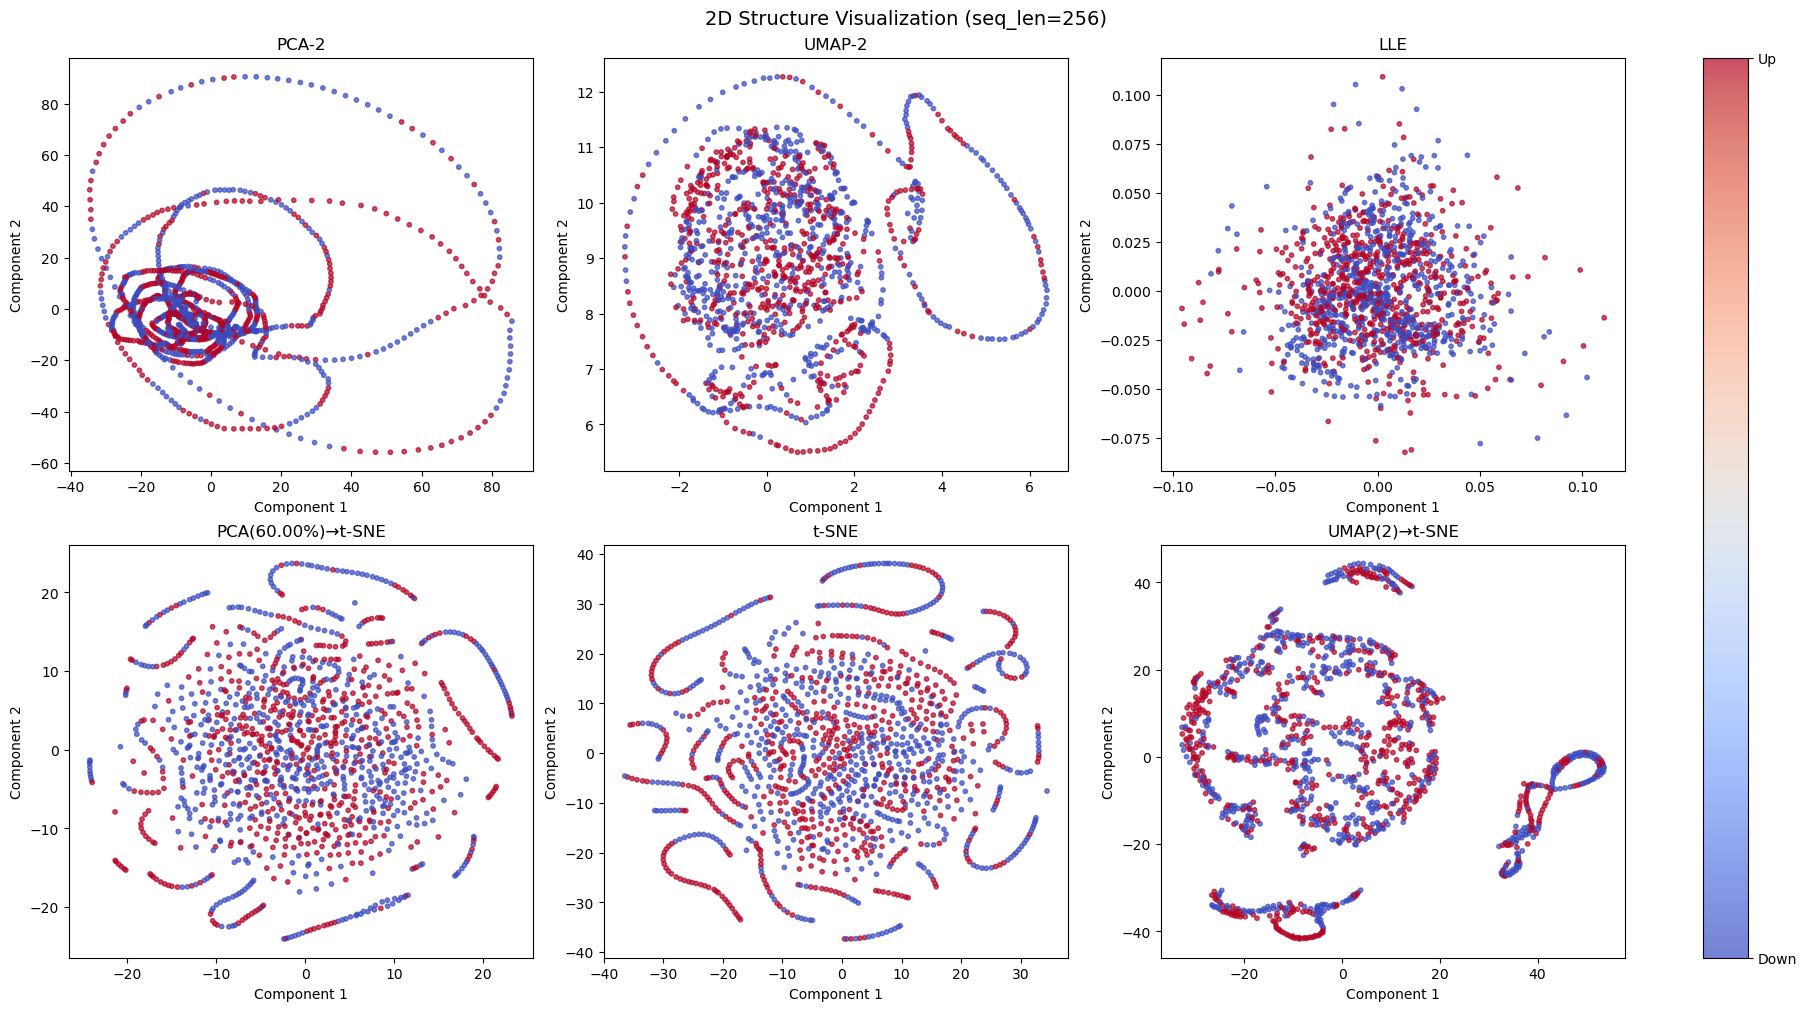

In [19]:
finfact.visualize_structure_2d (seq_len=256,
                                perplexity=30,
                                n_neighbors=10,
                                random_state=42,
                                pca_evp=0.6,
                                umap_components=2
                                )

/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Clustering eval: 100%|██████████| 9/9 [00:00<00:00, 27.63it/s]


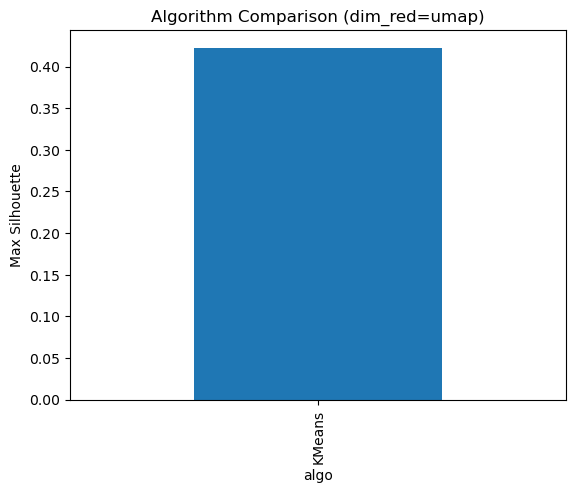

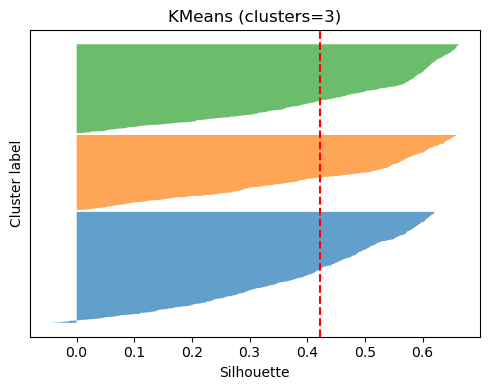

In [15]:
df_eval_report = finfact.evaluate_clusterings(
    dim_reduction='umap',
    reduction_params={'n_components': 2, 'n_neighbors': 10, 'min_dist': 0.1},
    algos= ['KMeans'],
    n_jobs=12,
    backend='thread',
    seq_len=1
)

In [ ]:
df_eval_report

In [ ]:
best_row = df_eval_report.loc[12]

In [ ]:
label_series = pd.Series(best_row['_labels'])
counts = label_series.value_counts()
print(counts)

#### IC分析

#### 相关性检测

In [ ]:
df_filtered = finfact.df_features.set_index('timestamp')

In [ ]:
corr = pd.DataFrame (df_filtered).corr ()
plt.figure (figsize=(12, 10))
sns.heatmap (corr, cmap='coolwarm', center=0)
plt.title ('Feature Correlation Matrix')
plt.show ()

#### PCA分析

In [ ]:
from sklearn.decomposition import PCA

pca = PCA ()
pca.fit (df_filtered)
percent = 0.99

cumulative = np.cumsum (pca.explained_variance_ratio_)
n_PCs = np.argmax (cumulative >= percent) + 1

print (f"前 {n_PCs} 个主成分累计解释了 {cumulative[n_PCs - 1]:.2%} 的方差")
feature_names = df_featured.columns

# 打印所有有重大贡献的主成分
for i in range (n_PCs):
    # 第 i 个主成分的系数
    pc = pca.components_[i]

    # 取绝对值最大的特征位置
    top_feature_idx = np.argmax (np.abs (pc))
    top_feature_name = feature_names[top_feature_idx]

    print (f"PC{i + 1} 的主导因子是: {top_feature_name}（贡献系数: {pc[top_feature_idx]:.4f}）")